In [50]:
import pandas as pd
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from sklearn import model_selection, feature_extraction,  preprocessing, metrics
import time

In [100]:
# Записываю результаты по разным моделям для сравнения
df_result = pd.DataFrame(columns=['Model_Type', 'Params', 'Accuracy', 'Time'])
def df_add(mdl, params, acr, tm):
    global df_result
    newline = {'Model_Type': mdl,'Params': params, 'Accuracy': acr, 'Time': tm}
    df_result = df_result.append(newline, ignore_index = True)

In [52]:
# Записываю результаты анализа в файл
def write_result(dt, mdl, file_name):
    predictions = mdl.predict(dt)
    output = pd.DataFrame({'PassengerId': submit_df.PassengerId, 'Survived': predictions.astype(int)})
    output.to_csv(file_name, index=False)
    print("Your submission was successfully saved!")

In [53]:
# Загрузка данных
folder_link = 'C:/Users/Andrei/Python files/ML course Yandex/Хорошие работы/Kaggel_Titanik/'
train_df = pd.read_csv(folder_link + 'train.csv')
submit_df = pd.read_csv(folder_link + 'test.csv')
union_df = pd.concat([train_df, submit_df], ignore_index=True) # Удобно для чистки и визуализации данных

In [54]:
train_df.shape

(891, 12)

In [55]:
submit_df.shape

(418, 11)

In [56]:
union_df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
1306,1307,NaN,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
1307,1308,NaN,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


# Анализ распределений в данных

In [57]:
# Логический порядок колонок
union_df = union_df[['PassengerId', 'Survived', 'Sex', 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare', 'Embarked', 'Ticket',  'Cabin']]  # +'Name'

clms_real = [ 'Pclass', 'SibSp', 'Parch', 'Age', 'Fare'] 
clms_cat = ['Sex', 'Embarked', 'Ticket',  'Cabin']
# clms_other = ['PassengerId', 'Name', 'Survived']

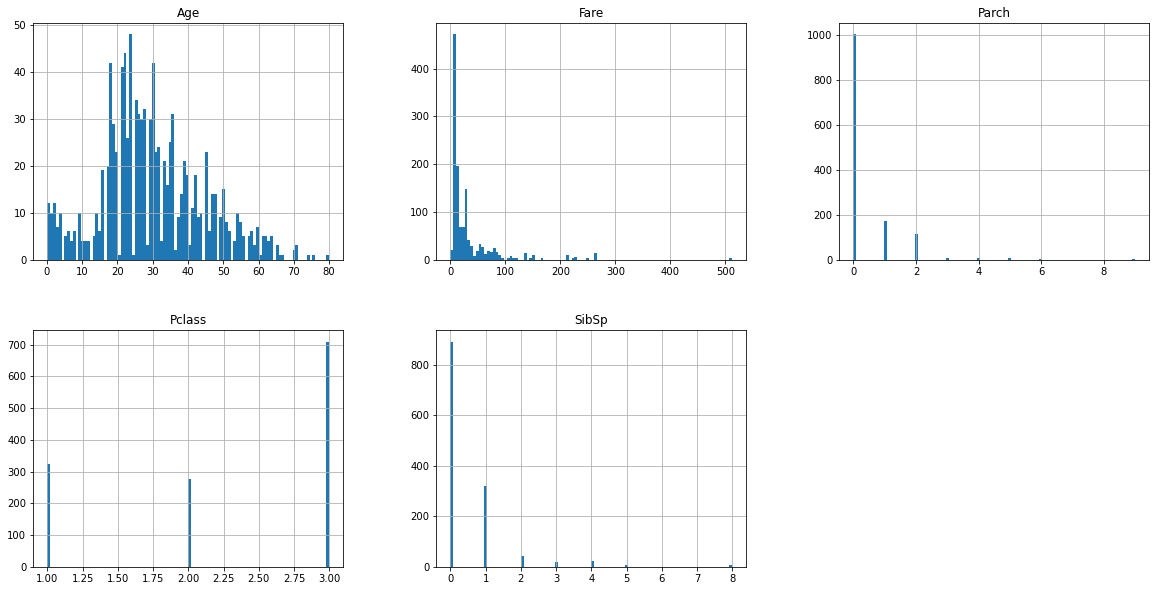

In [58]:
# Распределение действительных значений
union_df[clms_real].hist(bins=100, figsize=(20,10), layout = (2,3))
plt.show()
# Возможно есть выбросы в Fare
# Непонятно значение Parch > 2

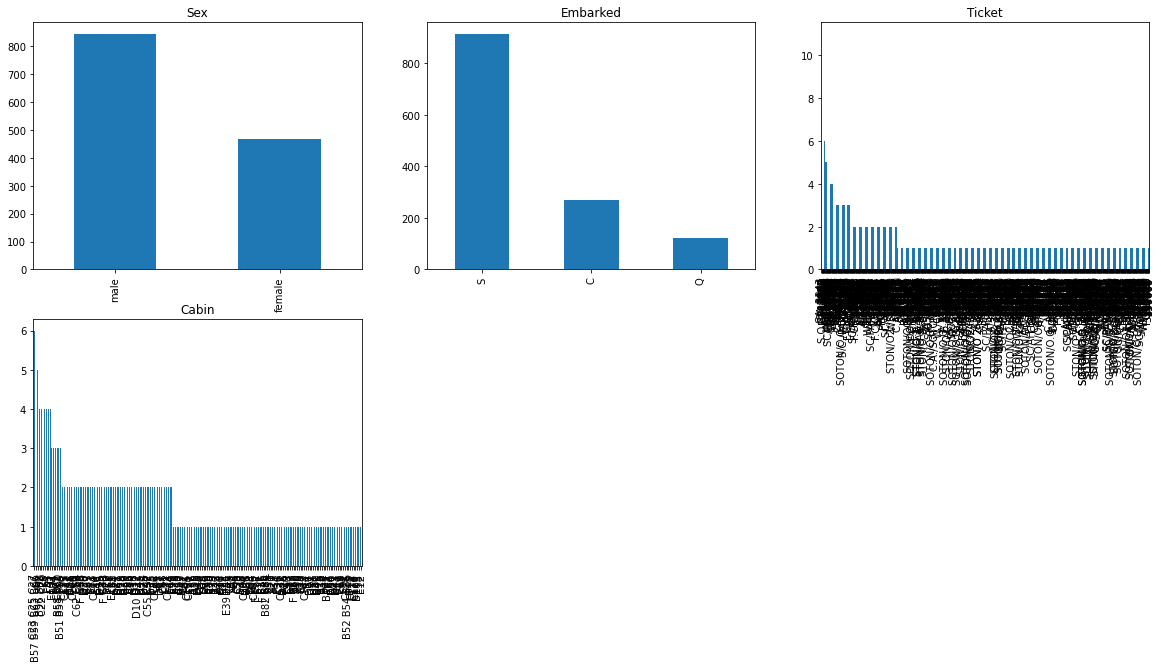

In [59]:
# Анализ категориальных данных
plt.figure(figsize = (20,10))
for i,col in enumerate(clms_cat):
    plt.subplot(2, 3, i+1)
    union_df[col].value_counts().plot(kind='bar')
    plt.title(col)

# Обработка NaN

In [60]:
pd.isnull(union_df).sum()
# Survived содержит NaN только в тестовых данных - это ок. Всё остальное нужно обработать!

PassengerId       0
Survived        418
Sex               0
Pclass            0
SibSp             0
Parch             0
Age             263
Fare              1
Embarked          2
Ticket            0
Cabin          1014
dtype: int64

In [61]:
# Сabin заменяем на NA 
union_df.Cabin.fillna('NA', inplace=True)

C:\Users\Andrei\Anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [62]:
# Embarked заменяем на моду 
union_df.Embarked.fillna(union_df['Embarked'].mode()[0], inplace = True)

In [63]:
# Fare заменяем на медиану
union_df.Fare.fillna(union_df['Fare'].mean(), inplace = True)

In [64]:
# Age заменяем медианой в соответствующем классе
union_df.groupby('Pclass').agg({'Age': 'mean'})

,Age
Pclass,
1,39.159930
2,29.506705
3,24.816367


In [65]:
Index_of_nan_age = pd.isnull(union_df[['Age']]).Age
union_df.loc[Index_of_nan_age & (union_df.Pclass == 1), 'Age'] = union_df[union_df.Pclass == 1].Age.mean()
union_df.loc[Index_of_nan_age & (union_df.Pclass == 2), 'Age'] = union_df[union_df.Pclass == 2].Age.mean()
union_df.loc[Index_of_nan_age & (union_df.Pclass == 3), 'Age'] = union_df[union_df.Pclass == 3].Age.mean()

C:\Users\Andrei\Anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [66]:
# Контрольная проверка
pd.isnull(union_df).sum()
# Survived содержит NaN только в тестовых данных - это ок.

PassengerId      0
Survived       418
Sex              0
Pclass           0
SibSp            0
Parch            0
Age              0
Fare             0
Embarked         0
Ticket           0
Cabin            0
dtype: int64

# Преобразование категориальных признаков

In [67]:
union_df['Sex'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
union_df['Embarked'].replace(to_replace=['C','Q', 'S'], value=[0,1,2],inplace=True)

C:\Users\Andrei\Anaconda3\lib\site-packages\pandas\core\generic.py:6746: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [68]:
union_df_dms = pd.get_dummies(union_df, prefix=['Ticket', 'Cabin'])

In [69]:
union_df_dms

,PassengerId,Survived,Sex,Pclass,SibSp,Parch,Age,Fare,Embarked,Ticket_110152,...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_NA,Cabin_T
0,1,0.0,0,3,1,0,22.000000,7.2500,2,0,...,0,0,0,0,0,0,0,0,1,0
1,2,1.0,1,1,1,0,38.000000,71.2833,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1.0,1,3,0,0,26.000000,7.9250,2,0,...,0,0,0,0,0,0,0,0,1,0
3,4,1.0,1,1,1,0,35.000000,53.1000,2,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0.0,0,3,0,0,35.000000,8.0500,2,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,1305,NaN,0,3,0,0,24.816367,8.0500,2,0,...,0,0,0,0,0,0,0,0,1,0
1305,1306,NaN,1,1,0,0,39.000000,108.9000,0,0,...,0,0,0,0,0,0,0,0,0,0
1306,1307,NaN,0,3,0,0,38.500000,7.2500,2,0,...,0,0,0,0,0,0,0,0,1,0
1307,1308,NaN,0,3,0,0,24.816367,8.0500,2,0,...,0,0,0,0,0,0,0,0,1,0


In [70]:
X_train_df = union_df_dms[union_df_dms['PassengerId'].isin(train_df.PassengerId)]
X_submit_df  = union_df_dms[union_df_dms['PassengerId'].isin(submit_df.PassengerId)]
Y = X_train_df['Survived'].values
X_train_df = X_train_df.drop(columns=['Survived','PassengerId'])
X_submit_df = X_submit_df.drop(columns=['Survived','PassengerId'])

# Все данные или нет?

In [71]:
# Если использую часть признаков, то:
X_train_df = X_train_df[['Sex', 'Pclass','SibSp','Parch','Age','Fare','Embarked']]
X_submit_df = X_submit_df[['Sex', 'Pclass','SibSp','Parch','Age','Fare','Embarked']]

# Масштабирование признаков

Масштабирование осуществляется посредством вычета из каждого признака среднего значения и нормировки на выборочное стандартное отклонение:

$$ x^{scaled}_{id} = \dfrac{x_{id} - \mu_d}{\sigma_d}, \quad \mu_d = \frac{1}{N} \sum_{i=1}^l x_{id}, \quad \sigma_d = \sqrt{\frac{1}{N-1} \sum_{i=1}^l (x_{id} - \mu_d)^2} $$

In [72]:
scaler_all = preprocessing.StandardScaler()
scaler_all.fit(X_train_df)
X_train = scaler_all.transform(X_train_df)
X_submit = scaler_all.transform(X_submit_df)

# Балансировка классов

Проверим, требуется ли балансировка классов (если один из классов представлен менее чем 10%)?

In [73]:
print('Баланс классов в исходной выборке:')
print('0 - ', round(sum(Y==0)/len(Y),2))
print('1 - ', round(sum(Y==1)/len(Y),2))

Баланс классов в исходной выборке:
0 -  0.62
1 -  0.38


# Разбиение на обучение и валидацию

In [74]:
# (X_train, X_test, Y_train, Y_test) = model_selection.train_test_split(X_train, Y_train, stratify=Y_train, test_size = 0.2)

# Посмотрим, насколько данные разделимы?

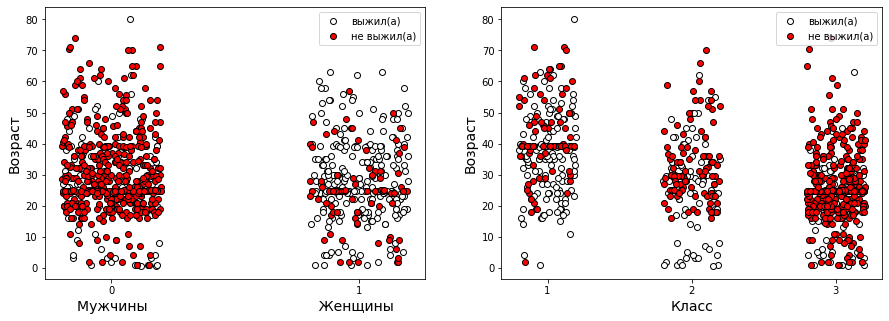

In [75]:
# Зависимость от пола/возраста
def jitter(arr):
    return arr + np.random.uniform(low=-0.2, high=0.2, size=len(arr))

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.scatter(jitter(X_train_df.Sex[Y==1].values), X_train_df.Age[Y==1].values, color='white', edgecolors="black", label = 'выжил(а)')
plt.scatter(jitter(X_train_df.Sex[Y==0].values), X_train_df.Age[Y==0].values, color='red', edgecolors="black", label = 'не выжил(а)')
plt.ylabel('Возраст', fontsize=14)
plt.xlabel('Мужчины                                      Женщины', fontsize=14)
plt.xticks([0,1])
plt.legend()

plt.subplot(1,2,2)
plt.scatter(jitter(X_train_df.Pclass[Y==1].values), X_train_df.Age[Y==1].values, color='white', edgecolors="black", label = 'выжил(а)')
plt.scatter(jitter(X_train_df.Pclass[Y==0].values), X_train_df.Age[Y==0].values, color='red', edgecolors="black", label = 'не выжил(а)')
plt.ylabel('Возраст', fontsize=14)
plt.xlabel('Класс', fontsize=14)
plt.xticks([1,2,3])
plt.legend(loc = 'upper right')
plt.show()

### TSNE

In [77]:
from sklearn.manifold import TSNE
import matplotlib.cm as cm # импортируем цветовые схемы, чтобы рисовать графики.

In [90]:
tsne = TSNE(n_components = 2, random_state = 321)
tsne_representation = tsne.fit_transform(X_train[:,0:7])

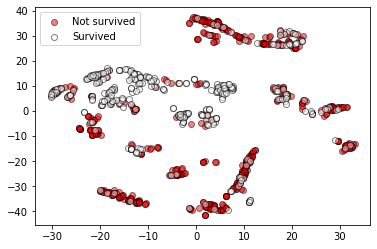

In [91]:
plt.scatter(tsne_representation[Y==0, 0], tsne_representation[Y==0, 1], color='red',edgecolors="black", alpha=0.5, label='Not survived')
plt.scatter(tsne_representation[Y==1, 0], tsne_representation[Y==1, 1], color='white', edgecolors="black", alpha=0.5, label='Survived')
plt.legend()
plt.show()

### MDS (metric= 'cityblock')

In [83]:
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import pairwise_distances

In [92]:
mds = MDS(n_components = 2, dissimilarity="precomputed", random_state = 321)
pair_dist_train = pairwise_distances(X_train[:,0:7], metric= 'cityblock')
X_train_mds = mds.fit_transform(pair_dist_train)

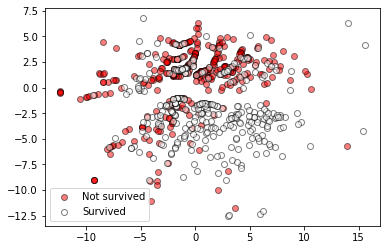

In [93]:
plt.scatter(X_train_mds[Y==0, 0], X_train_mds[Y==0, 1], color='red',edgecolors="black", alpha=0.5, label='Not survived')
plt.scatter(X_train_mds[Y==1, 0], X_train_mds[Y==1, 1], color='white', edgecolors="black", alpha=0.5, label='Survived')
plt.legend()
plt.show()

# Логистическая регрессия

In [94]:
from sklearn.linear_model import LogisticRegression

In [101]:
lrmodel = LogisticRegression()
lrmodel.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [102]:
# Настройка сетки подбора параметров
param_grid = {
    'solver': ['lbfgs', 'liblinear'],
    'penalty': ['l1', 'l2', None],
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'class_weight': ['balanced', None]
}
combination = sum([len(i) for i in param_grid.values()])

In [103]:
# All data
start_time = time.time()
optimizer = model_selection.GridSearchCV(lrmodel, param_grid, cv=3)
optimizer.fit(X_train, Y)
t = time.time() - start_time

C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 443, in _check_solver
    "got %s penalty." % (solver, penalty))
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  FitFailedWarning)
C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this

C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    " got %s." % (all_penalties, penalty))
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  FitFailedWarning)
C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit f

C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:552: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1304, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Andrei\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 439, in _check_solver
    " got %s." % (all_penalties, penalty))
ValueError: Logistic Regression supports only penalties in ['l1', 'l2', 'elasticnet', 'none'], got None.

  FitFailedWarning)


In [104]:
# Запишем результаты
df_add('Logistic regression', optimizer.best_params_, optimizer.best_score_, t/combination)

In [105]:
df_result

,Model_Type,Params,Accuracy,Time
0,Logistic regression,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.804714,0.062319


In [235]:
#write_result(X_submit, optimizer, 'LR.csv')

In [106]:
# Какие признаки наиболее сильно влияют на результат?

In [107]:
columns = ['Sex', 'Pclass','SibSp','Parch','Age','Fare','Embarked']
valuable_features = list()
for i, val in enumerate(optimizer.best_estimator_.coef_[0]):
    valuable_features.append([columns[i], round(val,3)])
sorted(valuable_features, key = lambda x: abs(x[1]),reverse=True)

[['Sex', 0.733],
 ['Pclass', -0.423],
 ['Age', -0.184],
 ['Fare', 0.164],
 ['SibSp', -0.134],
 ['Embarked', -0.132],
 ['Parch', -0.001]]

# SVM

In [108]:
from sklearn import svm
svm_model = svm.SVC()
svm_model.get_params().keys()

dict_keys(['C', 'break_ties', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

In [109]:
# Настройка сетки подбора параметров
param_grid = {
    'C': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'kernel': ['linear', 'poly', 'rbf'],
    'class_weight': ['balanced', None]    
}
combination = sum([len(i) for i in param_grid.values()])

In [110]:
# All data
start_time = time.time()
optimizer = model_selection.GridSearchCV(svm_model, param_grid, cv=3)
optimizer.fit(X_train, Y)
t = time.time() - start_time

In [112]:
# Запишем результаты
df_add('SVM (all)', optimizer.best_params_, optimizer.best_score_, t/combination)

In [113]:
df_result

,Model_Type,Params,Accuracy,Time
0,Logistic regression,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.804714,0.062319
1,SVM (all),"{'C': 1, 'class_weight': None, 'kernel': 'rbf'}",0.824916,0.177767


In [114]:
#write_result(X_submit, optimizer, 'SVM.csv')

# Случайный лес

In [115]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier()
rf_model.get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [116]:
# Настройка сетки подбора параметров
param_grid = {
    'random_state': [1],
    'n_jobs': [-1],
    'n_estimators': [50, 75, 100],
    'max_depth': [10, 15, 20]
}
combination = sum([len(i) for i in param_grid.values()])

In [117]:
# All data
start_time = time.time()
optimizer = model_selection.GridSearchCV(rf_model, param_grid, cv=3)
optimizer.fit(X_train, Y)
t = time.time() - start_time

In [119]:
# Запишем результаты
df_add('Random forest (all)', optimizer.best_params_, optimizer.best_score_, t/combination)

In [120]:
df_result

,Model_Type,Params,Accuracy,Time
0,Logistic regression,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.804714,0.062319
1,SVM (all),"{'C': 1, 'class_weight': None, 'kernel': 'rbf'}",0.824916,0.177767
2,Random forest (all),"{'max_depth': 10, 'n_estimators': 75, 'n_jobs'...",0.824916,1.787055


In [ ]:
#write_result(X_submit, optimizer, 'RF0207.csv')

# Gradient boosting

In [121]:
import xgboost as xgb
xgb_model = xgb.XGBClassifier()
xgb_model.get_params().keys()

dict_keys(['base_score', 'booster', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'n_jobs', 'nthread', 'objective', 'random_state', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample', 'verbosity'])

In [122]:
# Настройка сетки подбора параметров
param_grid = {
    'random_state': [1],
    'n_jobs': [-1],
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1, 5, 10],
    'max_depth': [3, 5],
    'n_estimators': [50, 75, 100]  
}
combination = sum([len(i) for i in param_grid.values()])

In [123]:
# All data
start_time = time.time()
optimizer = model_selection.GridSearchCV(xgb_model, param_grid, cv=3)
optimizer.fit(X_train, Y)
t = time.time() - start_time

In [124]:
# Запишем результаты
df_add('Gradient boosting (all)', optimizer.best_params_, optimizer.best_score_, t/combination)

In [125]:
df_result

,Model_Type,Params,Accuracy,Time
0,Logistic regression,"{'C': 0.01, 'class_weight': None, 'penalty': '...",0.804714,0.062319
1,SVM (all),"{'C': 1, 'class_weight': None, 'kernel': 'rbf'}",0.824916,0.177767
2,Random forest (all),"{'max_depth': 10, 'n_estimators': 75, 'n_jobs'...",0.824916,1.787055
3,Gradient boosting (all),"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.835017,1.200422


In [223]:
#write_result(X_submit, optimizer, 'Gradient_boosting_0207.csv')

Your submission was successfully saved!
